#Notes:
ERA data: mm/hr. CMIp (tigge?) data: kg/m^2/sec, accumulated total since lead time.
Make both same type- total added upto 6 hours. Q: why do we add dt/2 (i.e.3 hours) in CMIP?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns
from src.regrid import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [4]:
args = load_args('../nn_configs/B/138-resnet_prec.yml')

In [5]:
args['test_years']

('2017', '2018')

In [6]:
# args['train_years']=['2017', '2017']
# args['valid_years']=['2018-01-01','2018-03-31']
# args['test_years']=['2018-12-01','2018-12-31']
args['model_save_dir'] ='/home/garg/data/WeatherBench/predictions/saved_models'
args['datadir']='/home/garg/data/WeatherBench/5.625deg'
args['pred_save_dir']= '/home/garg/data/WeatherBench/predictions'
#args

## Load Data

In [7]:
valid = xr.open_mfdataset(f'{args["datadir"]}/6hr_precipitation/*.nc',combine='by_coords')

In [8]:
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [9]:
valid.tp.max().values, valid.tp.min().values, valid.tp.mean().values
#Why negative?

(array(0.1734646, dtype=float32),
 array(-1.1175871e-08, dtype=float32),
 array(0.00061558, dtype=float32))

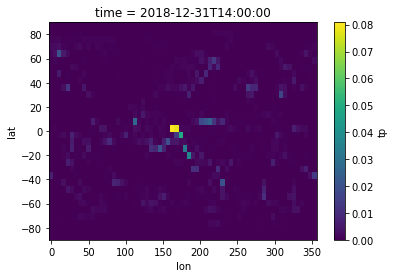

In [10]:
valid.tp.isel(time=-10).plot()

In [11]:
args['tp_log']

0.001

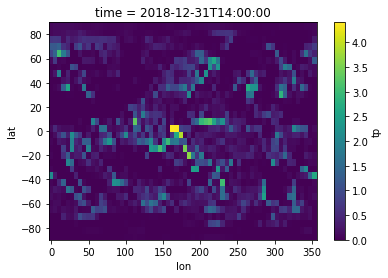

In [12]:
log_trans(valid.tp.isel(time=-10), args['tp_log']).plot()

In [13]:
logged_valid=log_trans(valid, args['tp_log'])

In [14]:
for i in range(10):
    print(valid.tp.isel(time=i, lat=10, lon=20).values,logged_valid.tp.isel(time=i, lat=10, lon=20).values)

-1.8626451e-09 -1.9073486e-06
-3.7252903e-09 -3.8146973e-06
-5.5879354e-09 -5.2452087e-06
-7.450581e-09 -7.1525574e-06
-9.313226e-09 -9.059906e-06
-1.1175871e-08 -1.0967255e-05
-1.1175871e-08 -1.0967255e-05
-1.1175871e-08 -1.0967255e-05
-1.1175871e-08 -1.0967255e-05
-1.1175871e-08 -1.0967255e-05


In [16]:
logged_valid.tp.max().values, logged_valid.tp.min().values, logged_valid.tp.mean().values

(array(5.161722, dtype=float32),
 array(-1.0967255e-05, dtype=float32),
 array(0.27909833, dtype=float32))

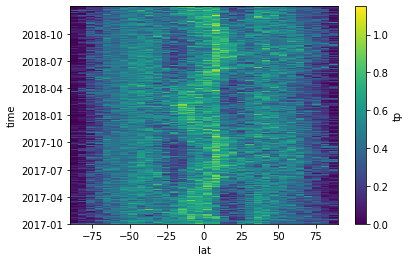

In [18]:
plt1=logged_valid.tp.std('lon').plot()

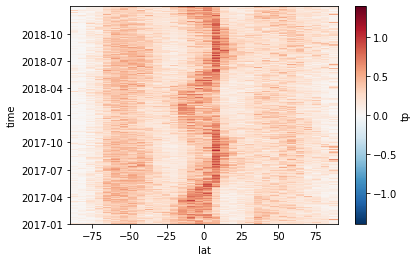

In [19]:
logged_valid.tp.mean('lon').plot()#lot near the equator. periodic.

# DataGenerator

In [9]:
args['ext_mean'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')

dg_test=load_data(**args, old_const=True, only_test=True)
#If old_const=False, shape = [...., old_shape-(nt_in-1)*no. of constants], i.e., for constants we only take 1 time step and not nt_in timesteps

In [131]:
len(dg_test), 273*32

(273, 8736)

In [126]:
x,y=dg_test[0]
x.shape, y.shape
#Though we dont use y here but remember it is log-transformed and needs to be retransformed 

((32, 32, 64, 120), (32, 32, 64, 1))

In [136]:
y.min(), y.max(), y.mean()

(-2.2114626e-05, 9.286499, 0.5273144)

In [138]:
for i in range(10):
    print(y[i,10,20,0], valid.tp.isel(time=i, lat=20, lon=20).values, logged_valid.tp.isel(time=i, lat=20, lon=20).values)
    #log_trans+normalized, ground truth (6hr accumulated),log_trans(valid) 

-2.2114626e-05 -1.1175871e-08 -1.0967255e-05
-2.2114626e-05 -1.1175871e-08 -1.0967255e-05
-2.2114626e-05 -1.1175774e-08 -1.0967255e-05
-2.2114626e-05 7.452499e-07 0.0007452965
-2.2114626e-05 3.7577872e-06 0.003750801
0.0014951411 3.7624384e-06 0.0037555695
0.0014951411 3.013316e-06 0.0030088425
0.0045248447 1.01630295e-08 1.001358e-05
0.0030104737 6.2464856e-09 6.198883e-06
0.003009512 -1.0567387e-09 -9.536743e-07


# Determinstic Prediction

In [19]:
model = keras.models.load_model(
    f'{args["model_save_dir"]}/{args["exp_id"]}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 
                   'lat_mse': tf.keras.losses.mse}
)
#RECHECK LOSS fn.!

In [9]:
#model.summary()

In [21]:
preds=model.predict(dg_test)

In [22]:
preds.shape

(336, 32, 64, 1)

In [23]:
print(preds.max(), preds.min(), preds.mean())
print(y.max(), y.min(), y.mean())

8.125 0.0 0.5428985
9.506225 0.0 0.56894815


In [24]:
valid.tp.max().values, valid.tp.min().values, valid.tp.mean().values

(array(0.1734646, dtype=float32),
 array(-1.1175871e-08, dtype=float32),
 array(0.00061558, dtype=float32))

In [25]:
preds=create_predictions(model, dg_test)

In [26]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 336)
Coordinates:
  * time     (time) datetime64[ns] 2018-12-04 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    tp       (time, lat, lon) float64 2.168e-19 2.168e-19 ... 0.0001251

In [27]:
preds.tp.max().values,preds.tp.min().values, preds.tp.mean().values

(array(0.05522785), array(2.16840434e-19), array(0.00043161))

# Monte Carlo Dropout

In [17]:
    model = keras.models.load_model(
    f'{args["model_save_dir"]}/{args["exp_id"]}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 
                   'lat_mse': tf.keras.losses.mse})
#RECHECK LOSS fn.!
    
    #adding dropout
    c = model.get_config()
    for l in c['layers']:
        if l['class_name'] == 'Dropout':
            l['inbound_nodes'][0][0][-1] = {'training': True}
    
    model2 = keras.models.Model.from_config(c, custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 'lat_mse': tf.keras.losses.mse})
    model2.set_weights(model.get_weights())

In [18]:
    ensemble_size=20
    
    dg=dg_test; multi_dt=False; verbose=0; no_mean=False
    
    level_names = dg.data.isel(level=dg.output_idxs).level_names
    level = dg.data.isel(level=dg.output_idxs).level
    
    preds = []
    for _ in tqdm(range(ensemble_size)):
        preds.append(model2.predict(dg.tfr_dataset or dg, verbose=verbose))
    
    preds = np.array(preds)
    

    preds = xr.DataArray(
        preds[0] if multi_dt else preds,
        dims=['member','time', 'lat', 'lon', 'level'],
        coords={'member':np.arange(ensemble_size),'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': level,
                'level_names': level_names
                },
    )
    # Unnormalize
    mean = dg.mean.isel(level=dg.output_idxs).values if not no_mean else 0
    std = dg.std.isel(level=dg.output_idxs).values
    preds = preds * std + mean
    
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

    # Reverse tranforms
    if hasattr(dg.mean, 'tp_log') and 'tp' in unique_vars:
        tp_idx = list(preds.level_names).index('tp')
        preds.values[..., tp_idx] = log_retrans(preds.values[..., tp_idx], dg.mean.tp_log)

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] == v]
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    preds=xr.merge(das)
    

In [ ]:
#

In [19]:
# preds.to_netcdf(f'{args["pred_save_dir"]}/{args["exp_id"]}_dr_0.1_m50.nc')
# print(f'saved on disk in {args["pred_save_dir"]}/{args["exp_id"]}_dr_0.1_m50.nc')

saved on disk in /home/garg/data/WeatherBench/predictions/138-resnet_prec_dr_0.1.nc


In [20]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 20, time: 8724)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    tp       (member, time, lat, lon) float64 2.168e-19 2.168e-19 ... 0.0001159

# Evaluation

In [20]:
preds=xr.open_dataset(f'{args["pred_save_dir"]}/{args["exp_id"]}_dr_0.1.nc')

In [21]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 20, time: 8724)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    tp       (member, time, lat, lon) float64 ...

In [22]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.002187

In [23]:
spread=compute_weighted_meanspread(preds)
rmse=compute_weighted_rmse(preds, valid)

spread_skill=spread/rmse
spread_skill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.1211

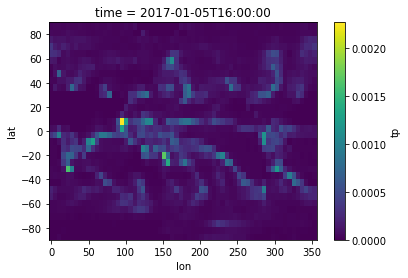

In [161]:
preds.tp.isel(time=20).std('member').plot()

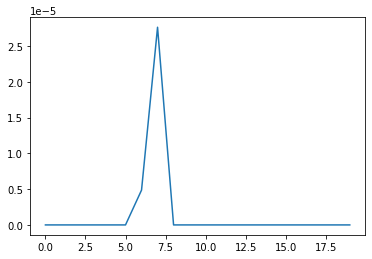

In [179]:
plt.plot(preds.tp.isel(time=50, lat=10, lon=20).values)

In [181]:
valid.tp.isel(time=50, lat=10, lon=20).values

array(1.4939228e-06, dtype=float32)

In [182]:
valid.tp.isel(time=50, lat=10, lon=20).values, preds.tp.isel(time=50, lat=10, lon=20).values

(array(1.4939228e-06, dtype=float32),
 array([2.16840434e-19, 2.16840434e-19, 2.16840434e-19, 2.16840434e-19,
        2.16840434e-19, 2.16840434e-19, 4.86239401e-06, 2.76165789e-05,
        2.16840434e-19, 2.16840434e-19, 2.16840434e-19, 2.16840434e-19,
        2.16840434e-19, 2.16840434e-19, 2.16840434e-19, 2.16840434e-19,
        2.16840434e-19, 2.16840434e-19, 2.16840434e-19, 2.16840434e-19]))

In [24]:
valid=valid.sel(time=preds.time)
compute_weighted_crps(preds, valid).load() #why too small.

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.0005855

In [25]:
# #!pip install rank-histogram
# from ranky import rankz

# obs_dr=valid.sel(time=preds.time)
# obs = np.asarray(obs_dr.to_array(), dtype=np.float32).squeeze();#small data

# pred=np.asarray(preds.sel(member=slice(0,10)).to_array(), dtype=np.float32).squeeze();

# mask=np.ones(obs.shape) #useless. #masked where 0/false.
# result = rankz(obs, pred, mask)
# plt.bar(range(1,pred.shape[0]+2), result[0])
# plt.show()

In [27]:
logged_valid=log_trans(valid, args['tp_log'])
logged_preds=log_trans(preds, args['tp_log'])
logged_valid=logged_valid.sel(time=logged_preds.time)

In [28]:
compute_weighted_rmse(logged_preds, logged_valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.4273

In [29]:
spread=compute_weighted_meanspread(logged_preds)
rmse=compute_weighted_rmse(logged_preds, logged_valid)

spread_skill=spread/rmse
spread_skill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.2159

In [30]:
logged_valid=logged_valid.sel(time=logged_preds.time)
compute_weighted_crps(logged_preds, logged_valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.2161

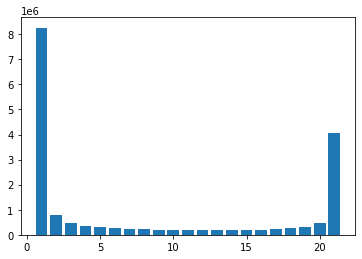

In [31]:
#!pip install rank-histogram
from ranky import rankz

obs_dr=logged_valid.sel(time=logged_preds.time)
obs = np.asarray(obs_dr.to_array(), dtype=np.float32).squeeze();#small data

pred=np.asarray(logged_preds.to_array(), dtype=np.float32).squeeze();

mask=np.ones(obs.shape) #useless. #masked where 0/false.
result = rankz(obs, pred, mask)
plt.bar(range(1,pred.shape[0]+2), result[0])
plt.show()

In [63]:
#only when raining
a=valid.where(valid.tp>0)
a

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8724)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T22:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(4344, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [65]:
a.tp.min().values, a.tp.max().values, a.tp.mean().values

(array(1.9619034e-21, dtype=float32),
 array(0.1734646, dtype=float32),
 array(0.00075816, dtype=float32))

In [67]:
compute_weighted_rmse(preds, a).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.002424

In [69]:
compute_weighted_crps(preds, a).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.0007054

# Final Script 

In [95]:
# exp_id_path='/home/garg/WeatherBench/nn_configs/B/138-resnet_prec.yml'
# model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
# datadir='/home/garg/data/WeatherBench/5.625deg'
# pred_save_dir='/home/garg/data/WeatherBench/predictions'


# !python create_dropout_ensemble.py 2 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir}